## Table of Contents
1. [Problem Statement](#1.-Problem-Statement)  
2. [Importing Libraries and Data](#2.-Importing-Libraries-and-Data)   
6. [Feature Engineering](#3.-Feature-Engineering)  
4. [Modeling](#4.-Modeling)  
5. [Model Evaluation](#5.-Model-Evaluation)  
6. [Recommendations and Conclusion](#6.-Recommendations-and-Conclusion)  
7. [Limitations](#7.-Limitations)
8. [Future Steps](#8.-Future-Steps)

# 1. Problem Statement
[Return to top](#Table-of-Contents)

The objective of this project is to design a regression model to predict resale prices of HDB flats, using past 5 years resale HDB data from [data.gov.sg](https://data.gov.sg/dataset/resale-flat-prices).

# 2. Importing Libraries and Data
[Return to top](#Table-of-Contents)

In [1]:
import numpy as np
import pandas as pd
# Pandas settings
pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
import re

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor


In [2]:
def create_copy(df): #creating a backup DataFrame for reverting to if something goes wrong
    df = df.copy()
    return df

In [3]:
df_hdb_cleaned = pd.read_csv(f"../data/df_hdb_cleaned.csv",parse_dates = ['date','lease_commence_date'])

In [4]:
df_hdb_cleaned_backup = create_copy(df_hdb_cleaned)

# 3. Feature Engineering
[Return to top](#Table-of-Contents)

Removing 'flat_type' & 'flat_model', in preparation of One Hot Encoding 'type_of_unit'.  

Removing 'street_name' as it is highly correlated to 'town', also in preparation of One Hot Encoding.  

Removing 'unit_price_$psf' as it is highly correlated to 'resale_price'  

Also One Hot Encode 'district' & 'storey_range'.

In [7]:
df_model = df_hdb_cleaned[['date', 'year_sold', 'month_sold', 'lease_commence_date',
                     'balance_lease', 'town', 'district', 'storey_range',
                     'type_of_unit', 'floor_area_sqft',
                     'resale_price']]

In [8]:
df_model.head()

date  year_sold  month_sold lease_commence_date  balance_lease  \
0 2017-01-01       2017           1          1979-01-01           61.0   
1 2017-01-01       2017           1          1978-01-01           60.0   
2 2017-01-01       2017           1          1980-01-01           62.0   
3 2017-01-01       2017           1          1980-01-01           62.0   
4 2017-01-01       2017           1          1980-01-01           62.0   

         town  district storey_range               type_of_unit  \
0  ANG MO KIO        20     10 TO 12        hdb 2 room improved   
1  ANG MO KIO        20     01 TO 03  hdb 3 room new generation   
2  ANG MO KIO        20     01 TO 03  hdb 3 room new generation   
3  ANG MO KIO        20     04 TO 06  hdb 3 room new generation   
4  ANG MO KIO        20     01 TO 03  hdb 3 room new generation   

   floor_area_sqft  resale_price  
0          473.616        232000  
1          721.188        250000  
2          721.188        262000  
3          731.952        265000  
4          721.188        265000

In [9]:
df_model = pd.get_dummies(data=df_model,
                          columns=['type_of_unit','district','storey_range', 'town'],
                          drop_first=True
                         )

In [10]:
df_model.head()

date  year_sold  month_sold lease_commence_date  balance_lease  \
0 2017-01-01       2017           1          1979-01-01           61.0   
1 2017-01-01       2017           1          1978-01-01           60.0   
2 2017-01-01       2017           1          1980-01-01           62.0   
3 2017-01-01       2017           1          1980-01-01           62.0   
4 2017-01-01       2017           1          1980-01-01           62.0   

   floor_area_sqft  resale_price  type_of_unit_hdb 2 room 2-room  \
0          473.616        232000                               0   
1          721.188        250000                               0   
2          721.188        262000                               0   
3          731.952        265000                               0   
4          721.188        265000                               0   

   type_of_unit_hdb 2 room dbss  type_of_unit_hdb 2 room improved  \
0                             0                                 1   
1                             0                                 0   
2                             0                                 0   
3                             0                                 0   
4                             0                                 0   

   type_of_unit_hdb 2 room model a  type_of_unit_hdb 2 room premium apartment  \
0                                0                                          0   
1                                0                                          0   
2                                0                                          0   
3                                0                                          0   
4                                0                                          0   

   type_of_unit_hdb 2 room standard  type_of_unit_hdb 3 room dbss  \
0                                 0                             0   
1                                 0                             0   
2                                 0                             0   
3                                 0                             0   
4                                 0                             0   

   type_of_unit_hdb 3 room improved  type_of_unit_hdb 3 room model a  \
0                                 0                                0   
1                                 0                                0   
2                                 0                                0   
3                                 0                                0   
4                                 0                                0   

   type_of_unit_hdb 3 room new generation  \
0                                       0   
1                                       1   
2                                       1   
3                                       1   
4                                       1   

   type_of_unit_hdb 3 room premium apartment  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   type_of_unit_hdb 3 room simplified  type_of_unit_hdb 3 room standard  \
0                                   0                                 0   
1                                   0                                 0   
2                                   0                                 0   
3                                   0                                 0   
4                                   0                                 0   

   type_of_unit_hdb 3 room terrace  type_of_unit_hdb 4 room adjoined flat  \
0                                0                                      0   
1                                0                                      0   
2                                0                                      0   
3                                0                                      0   
4       

In [11]:
df_model.shape

(125361, 112)

In [12]:
df_model_backup = create_copy(df_model)

# 4. Modeling
[Return to top](#Table-of-Contents)

## Baseline score

In [94]:
base_score = round(df_model['resale_price'].mean(),2)

print(f'Baseline score using mean of resale price: {base_score}')

Baseline score using mean of resale price: 464884.67


## Initial setup

In [15]:
def model_performance(test_data, predictions):
    mae = mean_absolute_error(test_data, predictions)
    rmse = np.sqrt(mean_squared_error(test_data, predictions))
    r2 = r2_score(test_data, predictions)
    print(f'MAE = {mae}')
    print(f'RMSE = {rmse}')
    print(f'R2 score = {r2}')

In [16]:
# Assemble our predictor variables (X) and our target (y)
X = df_model.drop(['resale_price','date','lease_commence_date'],axis=1)
y = df_model['resale_price']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [95]:
print(f'X_train shape: {X_train.shape}')
print()
print(f'X_test shape: {X_test.shape}')

X_train shape: (100288, 109)

X_test shape: (25073, 109)


In [18]:
# scaling 
ss = StandardScaler()
scaleX = ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

## Linear Regression

Linear regression is the most basic and commonly used predictive analysis. Regression estimates are used to describe data and to explain the relationship.  

$$ \huge y = \beta_0 + \beta_1 x_1 + \epsilon $$

In [19]:
# create instance of linear regression model
lr = LinearRegression()

lr.fit(X_train_scaled, y_train)
lr.score(X_train_scaled, y_train)

0.8709651847262447

In [20]:
lr.score(X_test_scaled,y_test) 
# slight overfitting; train score 0.87096 but test score 0.781725

0.7817255126744443

In [21]:
# 10-fold cross validation with multiple scoring metrics
lr_scores = cross_validate(estimator=lr,
                           X=X_train_scaled,
                           y=y_train,
                           scoring=['r2','neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error'],
                           cv=5
                          )

# format dictionary of scores into a dataframe
lr_scores = pd.DataFrame(lr_scores)

In [22]:
lr_scores

fit_time  score_time       test_r2  test_neg_mean_absolute_error  \
0  0.560397    0.000000  8.281305e-01                 -4.789052e+04   
1  0.576255    0.000000  8.729215e-01                 -4.355262e+04   
2  0.560217    0.000000 -1.465374e+22                 -1.323514e+14   
3  0.562431    0.015622  8.540029e-01                 -4.598391e+04   
4  0.561160    0.015622  8.035192e-01                 -5.801611e+04   

   test_neg_mean_squared_error  test_neg_root_mean_squared_error  
0                -3.822997e+09                     -6.183039e+04  
1                -3.167013e+09                     -5.627622e+04  
2                -3.513538e+32                     -1.874443e+16  
3                -3.355327e+09                     -5.792519e+04  
4                -5.748733e+09                     -7.582040e+04

In [23]:
lr_scores.mean()

fit_time                            5.640920e-01
score_time                          6.248808e-03
test_r2                            -2.930748e+21
test_neg_mean_absolute_error       -2.647028e+13
test_neg_mean_squared_error        -7.027077e+31
test_neg_root_mean_squared_error   -3.748887e+15
dtype: float64

In [24]:
lr.fit(X_train_scaled,y_train)
lr_preds = lr.predict(X_test_scaled)

print('LinearRegression')
model_performance(y_test,lr_preds)

LinearRegression
MAE = 56402.680771220825
RMSE = 72854.32156071156
R2 score = 0.7817255126744443


## K Nearest Neighbors

KNN regression is a non-parametric method that, in an intuitive manner, approximates the association between independent variables and the continuous outcome by averaging the observations in the same neighbourhood.  

![](https://snag.gy/hatSE6.jpg)

In [25]:
# %%time
# # create instance of knn regressor
# knn = KNeighborsRegressor()

# # set-up param_grid
# knn_param_grid = {'n_neighbors':list(range(1,11))
#                  }

# # set-up GridSearchCV
# knn_grid = GridSearchCV(estimator=knn,
#                         param_grid=knn_param_grid,
#                         scoring='neg_mean_squared_error',
#                         cv=5,
#                         verbose=2
#                        )

# # train knn grid search model
# knn_grid.fit(X_train_scaled, y_train)

In [26]:
# Fitting 5 folds for each of 10 candidates, totalling 50 fits
# ...
# Wall time: 20min 19s
# GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
#              param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
#              scoring='neg_mean_squared_error', verbose=2)

In [27]:
# knn_grid.best_params_
# {'n_neighbors': 5}

In [29]:
%%time
knn_model = KNeighborsRegressor(n_neighbors=5)

knn_model.fit(X_train_scaled,y_train)
knn_preds = knn_model.predict(X_test_scaled)
print('KNeighborsRegressor')
model_performance(y_test,knn_preds)

KNeighborsRegressor
MAE = 60598.26659753519
RMSE = 76563.52925311578
R2 score = 0.7589338516344656
Wall time: 40.4 s


## Random Forest Regressor

Random Forest Regression is a supervised learning algorithm that uses ensemble learning method for regression. Ensemble learning method is a technique that combines predictions from multiple machine learning algorithms to make a more accurate prediction than a single model.  

Random forests differ from bagging decision trees in only one way: they use a modified tree learning algorithm that selects, at each split in the learning process, a **random subset of the features**. This process is sometimes called the *random subspace method*.  

In [30]:
# %%time
# # create instance of random forest regressor
# rfr = RandomForestRegressor()

# # set-up param grid for GridSearchCV
# rfr_param_grid = {'n_estimators':[25,50,100,200],
#                   'max_features':['auto'],
#                   'bootstrap':[True,False],
#                  }

# # set-up GridSearchCV
# rfr_grid = GridSearchCV(estimator=rfr,
#                         param_grid=rfr_param_grid,
#                         scoring='neg_mean_squared_error',
#                         cv=5,
#                         verbose=2
#                        )

# # train rfr grid search model
# rfr_grid.fit(X_train,y_train)

In [31]:
# Fitting 5 folds for each of 8 candidates, totalling 40 fits
# ...
# Wall time: 46min 24s
# GridSearchCV(cv=5, estimator=RandomForestRegressor(),
#              param_grid={'bootstrap': [True, False], 'max_features': ['auto'],
#                          'n_estimators': [25, 50, 100, 200]},
#              scoring='neg_mean_squared_error', verbose=2)

In [32]:
# rfr_grid.best_params_
# {'bootstrap': True, 'max_features': 'auto', 'n_estimators': 100}

In [33]:
%%time
rfr_model = RandomForestRegressor(n_estimators=100,
                                  bootstrap=True,
                                  max_features='auto',
                                  oob_score=True
                                 )

rfr_model.fit(X_train,y_train)
rfr_preds = rfr_model.predict(X_test)
print('RandomForestRegressor')
model_performance(y_test,rfr_preds)
print(f'OOB score = {rfr_model.oob_score_}')

RandomForestRegressor
MAE = 51532.77627784919
RMSE = 67365.9457900238
R2 score = 0.8133735636552747
OOB score = 0.9482142856990798
Wall time: 1min 16s


## AdaBoost Regressor

$$ AdaBoost(X) = sign\left(\sum_{t=1}^T\alpha_t h_t(X)\right) $$

Where:

$AdaBoost(X)$ is the classification predictions for $y$ using predictor matrix $X$.

$T$ is the set of "weak learners.”

$\alpha_t$ is the contribution weight for weak learner $t$.

$h_t(X)$ is the prediction of weak learner $t$.

$y$ is binary **with values of negative one and one.*

In [35]:
# %%time
# # create instance of AdaBoostRegressor
# adaboost = AdaBoostRegressor()

# set-up param grid for GridSearchCV
# adaboost_param_grid = {'n_estimators':[1,5,25,50], 
#                        'learning_rate':[1,0.5,0.1,0.05,0.01]
#                       }
    
# # set-up GridSearchCV
# adaboost_grid = GridSearchCV(estimator=adaboost,
#                              param_grid=adaboost_param_grid,
#                              scoring='neg_mean_squared_error',
#                              cv=5,
#                              verbose=2
#                             )

# # train adaboost grid search model
# adaboost_grid.fit(X_train,y_train)

In [36]:
# Fitting 5 folds for each of 20 candidates, totalling 100 fits
# ...
# Wall time: 14min 45s
# GridSearchCV(cv=5, estimator=AdaBoostRegressor(),
#              param_grid={'learning_rate': [1, 0.5, 0.1, 0.05, 0.01],
#                          'n_estimators': [1, 5, 25, 50]},
#              scoring='neg_mean_squared_error', verbose=2)

In [37]:
# adaboost_grid.best_params_
# {'learning_rate': 1, 'n_estimators': 5}

In [38]:
%%time
adaboost_model = AdaBoostRegressor(n_estimators=5,
                                   learning_rate = 1
                                  )

adaboost_model.fit(X_train,y_train)
adaboost_preds = adaboost_model.predict(X_test)
print('AdaBoostRegressor')
model_performance(y_test,adaboost_preds)

AdaBoostRegressor
MAE = 74857.6496151598
RMSE = 115661.10762279063
R2 score = 0.44986783964412214
Wall time: 2.72 s


## Gradient Boosting Regressor

Gradient boosting is a machine learning technique used in regression and classification tasks, among others. It gives a prediction model in the form of an ensemble of weak prediction models, which are typically decision trees.  

**The advantages of GBRT are:**

- Natural handling of mixed data types (= heterogeneous features).
- Predictive power.
- Robustness to outliers in output space (via robust loss functions).

**The disadvantages of GBRT are:**
- Scalability: Due to the sequential nature of boosting, it can hardly be parallelized.
- Difficult hyperparameters to tune.

In [39]:
# %%time
# # create instance of GradientBoostingRegressor
# gb = GradientBoostingRegressor()

# # set-up param grid for GridSearchCV
# gb_param_grid = {'n_estimators':[50,100,150],
#                  'learning_rate':[0.5,0.1,0.05],
#                  'max_depth':[3,4,5]
#                 }
    
# # set-up GridSearchCV
# gb_grid = GridSearchCV(estimator=gb,
#                        param_grid=gb_param_grid,
#                        scoring='neg_root_mean_squared_error',
#                        cv=5,
#                        verbose=2
#                       )

# # train gb grid search model
# gb_grid.fit(X_train,y_train)

In [40]:
# Fitting 5 folds for each of 27 candidates, totalling 135 fits
# ...
# Wall time: 45min 11s
# GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
#              param_grid={'learning_rate': [0.5, 0.1, 0.05],
#                          'max_depth': [3, 4, 5],
#                          'n_estimators': [50, 100, 150]},
#              scoring='neg_root_mean_squared_error', verbose=2)

In [41]:
# gb_grid.best_params_
# {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 150}

In [42]:
%%time
gb_model = GradientBoostingRegressor(learning_rate=0.5,
                                     max_depth=5,
                                     n_estimators=150    
                                    )

gb_model.fit(X_train,y_train)
gb_preds = gb_model.predict(X_test)
print('GradientBoostingRegressor')
model_performance(y_test,gb_preds)

GradientBoostingRegressor
MAE = 44391.57974458614
RMSE = 58928.81327558361
R2 score = 0.8571935804068923
Wall time: 46.4 s


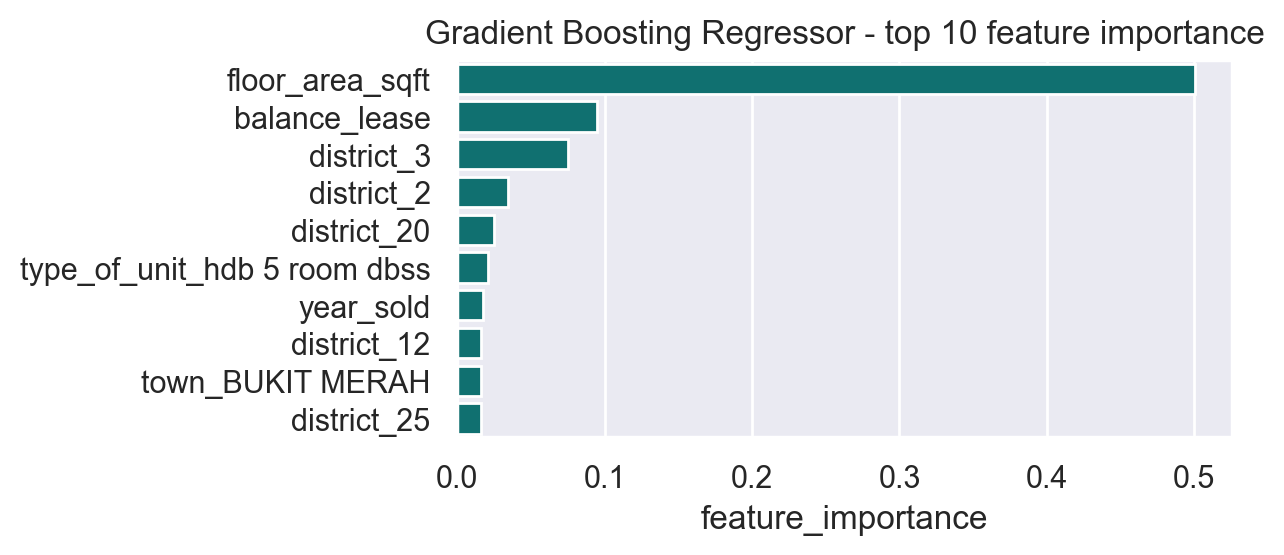

In [102]:
# create dataframe to store feature importances for RFR
gb_model_feature_importance = pd.DataFrame(data=gb_model.feature_importances_,
                                           index=X.columns,
                                           columns=['feature_importance']
                                          )

gb_data = gb_model_feature_importance.sort_values(by='feature_importance',ascending=False).head(10)
gb_x = gb_model_feature_importance.sort_values(by='feature_importance',ascending=False).head(10).index

# create visualization
plt.figure(figsize=(5,2.5),dpi=200)
sns.set(font_scale = 1)
sns.barplot(data=gb_data,
            x='feature_importance',
            y=gb_x,
            color='teal'
           )
plt.title('Gradient Boosting Regressor - top 10 feature importance')
plt.show()

In [45]:
gb_model_feature_importance.sort_values(by='feature_importance',ascending=False).head(10)

feature_importance
floor_area_sqft                         0.500627
balance_lease                           0.094834
district_3                              0.075229
district_2                              0.034446
district_20                             0.025050
type_of_unit_hdb 5 room dbss            0.021121
year_sold                               0.017431
district_12                             0.016227
town_BUKIT MERAH                        0.016148
district_25                             0.016086

In [46]:
gb_model_feature_importance.sort_values(by='feature_importance',ascending=False).tail(10)

feature_importance
type_of_unit_hdb 4 room terrace                       3.466537e-05
type_of_unit_hdb 2 room model a                       2.003404e-05
type_of_unit_hdb 4 room type s1                       1.457134e-05
type_of_unit_hdb 2 room improved                      5.937052e-06
district_17                                           3.709618e-06
type_of_unit_hdb executive adjoined flat              1.119571e-06
type_of_unit_hdb 2 room dbss                          7.532276e-07
type_of_unit_hdb 5 room premium apartment loft        4.036722e-07
type_of_unit_hdb 2 room 2-room                        3.662676e-07
type_of_unit_hdb 2 room premium apartment             0.000000e+00

# 5. Model Evaluation  
[Return to top](#Table-of-Contents)

|           MODEL           	|    MAE    	|    RMSE    	|   R2  	|
|:-------------------------:	|:---------:	|:----------:	|:-----:	|
| GradientBoostingRegressor 	| 44358.877 	|  58879.978 	| 0.857 	|
|   RandomForestRegressor   	| 51356.424 	|  67362.893 	| 0.813 	|
|      LinearRegression     	| 56402.681 	|  72854.322 	| 0.782 	|
|    KNeighborsRegressor    	| 60598.267 	|  76563.529 	| 0.759 	|
|     AdaBoostRegressor     	| 71504.518 	| 105946.896 	| 0.538 	|

In [97]:
# joint plot for visualizing Actual SalePrice vs Predicted SalePrice for X_train
plt.figure(figsize=(20,20),dpi=200)

j_plot = sns.jointplot(x = gb_model.predict(X_train),
                       y = y_train,
                       height=10,
                       ratio=7,
                       marginal_ticks=True,
                       xlim=(0, 1.4e6), 
                       ylim=(0, 1.4e6)
                      )

j_plot.fig.suptitle("GradientBoostingRegressor Actual SalePrice vs Predicted SalePrice (Train Set)", fontsize=20)
j_plot.set_axis_labels("Predicted Sale Price", "Actual Sale Price", fontsize=15)

x0, x1 = j_plot.ax_joint.get_xlim()
y0, y1 = j_plot.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
j_plot.ax_joint.plot(lims, lims, 'green')
sns.set(font_scale=1.5)

j_plot.fig.tight_layout();

<Figure size 4000x4000 with 0 Axes>

# 6. Recommendations and Conclusion  
[Return to top](#Table-of-Contents)

Gradient Boosting Regressor performed the best with an R2 score of 0.857 and RMSE of 58,879.98.  

This model has feature importance as shown below. From the chart, we can conclude that the floor area has the most impact on resale price, followed by the balance lease of the project and thridly its location.   


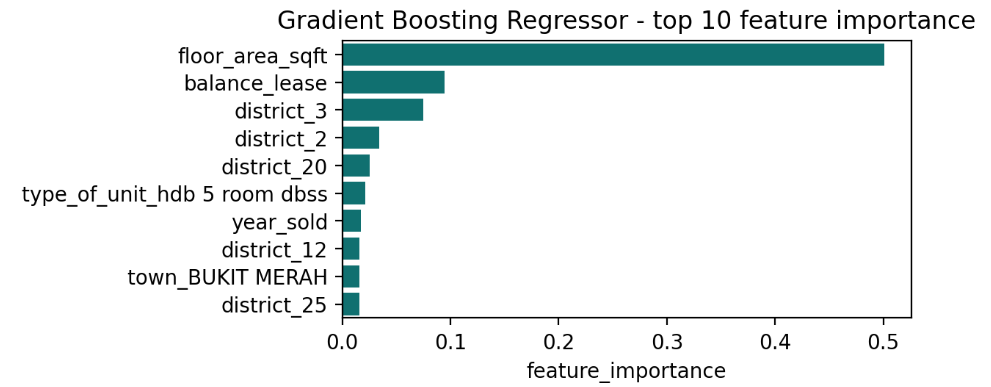

# 7. Limitations
[Return to top](#Table-of-Contents)

Some limitations were observed during this exercise.  

They include, but are not limited to: 
- External factors affecting decisions to sell (COVID19)
- Condition of unit when sold
- Years from last major renovation
- Orientation of flat
- Views (blocked/unblocked)

# 8. Future Steps
[Return to top](#Table-of-Contents)

- Include private property data from URA to build a more comprehensive and inclusive model for all real estate types in Singapore
- Consider to impute/engineer other features:
    - Proximity to amenities, transportation, shopping malls, super markets, wet markets, schools
    - Age group of seller/family, income bracket (single/dual income), primary mode of transportation
- Deployment of model for front end GUI